In [59]:
import numpy as np 
import os 
import torch 
from utils import _load_vocab
from torch.utils.data import Dataset,DataLoader
import librosa
import numpy as np 
import pandas as pd 
import librosa.display
import ast 
from sampler import edit_distance
from abc import ABC,abstractmethod


VOCAB_DICT=_load_vocab()

# Dataloader class
class MultiViewDataset(Dataset,ABC):
    def __init__(self, csv_file,max_mfcc_len,n_mfcc=13):
        self.data=pd.read_csv(csv_file)
        self.dir_path=os.path.dirname(csv_file)
        self.vocab_dict=VOCAB_DICT
        self.n_mfcc=n_mfcc
        self.max_mfcc_len=max_mfcc_len

    def __len__(self):
        return len(self.data)
    
    def char_to_idx(self, transcript):
        one_hot = torch.zeros(len(transcript), len(self.vocab_dict))
        for i, char in enumerate(transcript):
            one_hot[i, self.vocab_dict[char]] = 1
        return one_hot
    
    def compute_mfcc(self, audio_path):
        y, sr = librosa.load(audio_path)
        n_fft = min(2048, len(y))
        hop_length = n_fft // 4

        mfccs = librosa.feature.mfcc(y=y, sr=sr, 
                                     n_mfcc=self.n_mfcc, 
                                     n_fft=n_fft, 
                                     hop_length=hop_length)

        width = min(9, mfccs.shape[1])
        if width < 3:
            width = 3
        
        width = min(width, mfccs.shape[1])

        if width % 2 == 0:
            width -= 1

        delta1 = librosa.feature.delta(mfccs, order=1, width=width)
        delta2 = librosa.feature.delta(mfccs, order=2, width=width)

        mfccs_combined = np.concatenate((mfccs, delta1, delta2), axis=0)
        return mfccs_combined
    
    @abstractmethod
    def __getitem__(self, idx):
        pass

class MultiViewTrainDataset(MultiViewDataset):
    def __init__(self,csv_file,loss_fn,max_mfcc_len,n_mfcc=13):
        super().__init__(csv_file, max_mfcc_len=max_mfcc_len,n_mfcc=n_mfcc)
        self.loss_fn=loss_fn
    
    def __getitem__(self,idx):
        
        audio_path_x1=self.data["audio_path"][idx]
        audio_path_x1=os.path.join(self.dir_path,str(audio_path_x1))
        transcript_c1=self.data["transcript"][idx]

        sample_list=ast.literal_eval(self.data["negative_samples"][idx])
        
        one_hot_c2=None
        if 0 in self.loss_fn or 1 in self.loss_fn:
            transcript_c2=sample_list[0]
            one_hot_c2=self.char_to_idx(transcript_c2)
            lev_distance=edit_distance(transcript_c1,transcript_c2)
        
        mfccs_x2=None
        if 2 in self.loss_fn or 3 in self.loss_fn:
            audio_path_x2=sample_list[1]
            audio_path_x2=os.path.join(self.dir_path,str(audio_path_x2))

            mfccs_x2=self.compute_mfcc(audio_path_x2)
        
        #computing mfcc
        mfcc_x1=self.compute_mfcc(audio_path_x1) 
        
        #computiing one hot for transcript 
        one_hot_c1=self.char_to_idx(transcript_c1)

        output_tensors= [torch.tensor(mfcc_x1), one_hot_c1]

        if 0 in self.loss_fn or 1 in self.loss_fn:
            output_tensors.append(one_hot_c2)
            output_tensors.append(lev_distance)
    
        if 2 in self.loss_fn or 3 in self.loss_fn:
            output_tensors.append(torch.tensor(mfccs_x2))
    
        return output_tensors

class MultiViewDevDataset(MultiViewDataset):
    def __init__(self,csv_file,max_mfcc_len,n_mfcc=13):
        super().__init__(csv_file,max_mfcc_len=max_mfcc_len,n_mfcc=n_mfcc)
    
    def __getitem__(self,idx):
        
        audio_path_x1=self.data["audio_path"][idx]
        audio_path_x1=os.path.join(self.dir_path,str(audio_path_x1))

        #mfcc 
        audio_mfcc=self.compute_mfcc(audio_path_x1)

        sample_dict=ast.literal_eval(self.data["sampled_words"][idx])
        lev_scores=[]
        for score in sample_dict.keys():
            for _ in range(len(sample_dict[score])):
                lev_scores.append(score)

        one_hot=[]
        for transcripts in sample_dict.values():
            for transcript in transcripts:
                one_hot.append(self.char_to_idx(transcript))
        
        one_hot_c1=self.char_to_idx(self.data['transcript'][idx])

        #sampling negative
        one_hot_c2=self.char_to_idx(ast.literal_eval(self.data["negative_samples"][idx])[0])
        audio_path_x2=ast.literal_eval(self.data["negative_samples"][idx])[1]
        audio_path_x2=os.path.join(self.dir_path,str(audio_path_x2))
        mfcc_x2=self.compute_mfcc(audio_path_x2)
        
        output_tensor=[torch.tensor(audio_mfcc),one_hot,
                       torch.tensor(lev_scores),one_hot_c1,one_hot_c2,
                       torch.tensor(mfcc_x2)]

        return output_tensor

# colate functions 
def train_collate_fn(batch,max_mfcc_len):

    mfccs_x1= []
    one_hot_c1=[]
    one_hot_c2=[]
    mfccs_x2=[]
    lev_distances=[]

    for item in batch:
        mfcc_x1,oh_c1 = item[0], item[1]
        mfccs_x1.append(mfcc_x1)
        one_hot_c1.append(oh_c1)

        if len(item) == 5:
            oh_c2,lev_distance,mfcc_x2= item[2], item[3],item[4]
            one_hot_c2.append(oh_c2)
            mfccs_x2.append(mfcc_x2)
            lev_distances.append(lev_distance)
        elif len(item)==4:
            if item[2].shape[1]==len(VOCAB_DICT):
                oh_c2,lev_distance=item[2],item[3]
                one_hot_c2.append(oh_c2)
                lev_distances.append(lev_distance)
        elif len(item) == 3:
            mfcc_x2=item[2]
            mfccs_x2.append(mfcc_x2)
    
    #max_mfcc_len = batch[0].dataset.max_mfcc_len

    mfccs_x1=pad_mfccs(mfccs_x1,max_mfcc_len)
    one_hot_c1=pad_sequence(one_hot_c1, batch_first=True)

    result={'view1_x1':mfccs_x1,'view2_c1':one_hot_c1}

    if one_hot_c2 and lev_distances:
        one_hot_c2=pad_sequence(one_hot_c2,batch_first=True)
        result['view2_c2']=one_hot_c2
        result['edit_distance']=lev_distances

    if mfccs_x2:
        mfccs_x2=pad_mfccs(mfccs_x2, max_mfcc_len)
        result['view1_x2']=mfccs_x2
    
    return result 
def dev_collate_fn(batch,max_mfcc_len):
    
    mfccs_x1=[]
    one_hot=[]
    lev_scores=[]
    one_hot_c1=[]
    one_hot_c2=[]
    mfccs_x2=[]

    for item in batch:
        mfcc_x1,oh,lev_score,oh_c1,oh_c2,mfcc_x2=item[0],item[1],item[2],item[3],item[4],item[5]
        mfccs_x1.append(mfcc_x1)
        one_hot.append(oh)
        lev_scores.append(lev_score)
        one_hot_c1.append(oh_c1)
        one_hot_c2.append(oh_c2)
        mfccs_x2.append(mfcc_x2)
    
    #max_mfcc_len=batch[0].dataset.max_mfcc_len
    mfccs_x1=pad_mfccs(mfccs_x1,max_mfcc_len)
    mfccs_x2=pad_mfccs(mfccs_x2,max_mfcc_len)

    one_hot=pad_batch_sequence(one_hot)

    one_hot_c1=pad_sequence(one_hot_c1,batch_first=True)
    one_hot_c2=pad_sequence(one_hot_c2,batch_first=True)

    results={"mfcc":mfccs_x1,
             "sampled_one_hot":one_hot,
             "lev_scores":torch.stack(lev_scores),
             "ground_truth":one_hot_c1,
             "one_hot_c2":one_hot_c2,
             "mfcc_x2":mfccs_x2}

    return results

# Padding functions
def pad_mfccs(mfccs, max_len):
    padded_mfccs = []
    for mfcc in mfccs:
        # Padding to the right with zeros
        pad_width = max_len - mfcc.shape[1]
        padded_mfcc = torch.nn.functional.pad(mfcc, (0, pad_width), 'constant', 0)
        padded_mfccs.append(padded_mfcc)
    return torch.stack(padded_mfccs)

def pad_sequence(sequences, batch_first=False, padding_value=0):
    return torch.nn.utils.rnn.pad_sequence(sequences, batch_first=batch_first, padding_value=padding_value)

def pad_batch_sequence(batch, padding_value=0):
    padded_batch = []

    max_seq_length = max(len(seq) for sequences in batch for seq in sequences)
    max_num_sequences = max(len(sequences) for sequences in batch)
    
    for sequences in batch:
        padded_sequences = [
            torch.nn.functional.pad(torch.tensor(seq), 
                                    (0, 0, 0, max_seq_length - len(seq)), 
                                    'constant', padding_value)
            for seq in sequences
        ]
        
        padded_sequences = pad_sequence(padded_sequences, batch_first=True, padding_value=padding_value)
        
        if len(padded_sequences) < max_num_sequences:
            padding = torch.full((max_num_sequences - len(padded_sequences), 
                                  max_seq_length, 
                                  padded_sequences.shape[2]), 
                                  padding_value)
            padded_sequences = torch.cat((padded_sequences, padding), dim=0)
        
        padded_batch.append(padded_sequences)
    
    stacked_tensor = torch.stack(padded_batch)

    return stacked_tensor

# loaders
def get_train_loader(csv_file,batch_size,loss_fn,max_mfcc_len):

    dataset=MultiViewTrainDataset(csv_file=csv_file,loss_fn=loss_fn,max_mfcc_len=max_mfcc_len)

    loader=DataLoader(dataset, batch_size=batch_size, 
                      collate_fn=lambda batch: train_collate_fn(batch, dataset.max_mfcc_len))

    return loader

def get_dev_loader(csv_file,batch_size,max_mfcc_len):
    
    dev_dataset=MultiViewDevDataset(csv_file=csv_file,max_mfcc_len=max_mfcc_len)

    dev_loader=DataLoader(dev_dataset, batch_size=batch_size, 
                          collate_fn=lambda batch: dev_collate_fn(batch, dev_dataset.max_mfcc_len))

    return dev_loader
    

In [60]:
root_path='/home/ubuntu/acoustic_stuff/hindi-acoustic-word-embedding/dataset/train_aligned_dataset'
dev_csv='sample_bhashini_dev.csv'
train_csv='sample_bhashini_train.csv'

In [61]:
from utils import _load_config
config_file=_load_config()

In [62]:
dataset=MultiViewTrainDataset(csv_file=os.path.join(root_path,train_csv),loss_fn=config_file['loss_fn'],max_mfcc_len=config_file['max_mfcc_train'])

In [67]:
sequences=[]
for i in range(32):
    word=dataset[i][1]
    sequences.append(word)
    

In [68]:
len(sequences)

32

In [76]:
sequences[5].shape

torch.Size([4, 83])

In [77]:
import torch
from torch.nn.utils.rnn import pad_sequence

def pad_batch_to_fixed_length(batch, max_seq_len, padding_value=0):
   
    padded_sequences = []
    for seq in batch:
        seq_len = seq.size(0)
        padded_seq = torch.zeros(max_seq_len, seq.size(1), dtype=torch.long)
        padded_seq[:seq_len] = seq[:seq_len]
        padded_sequences.append(padded_seq)

    padded_batch = pad_sequence(padded_sequences, batch_first=True, padding_value=padding_value)

    return padded_batch


In [80]:
padded_sequences = [torch.cat([seq, torch.zeros(20 - seq.size(0), seq.size(1), device=seq.device)], dim=0) for seq in sequences]


In [87]:
df=pd.read_csv(os.path.join(root_path,train_csv))
df['length']=df['transcript'].apply(len)

In [88]:
max(df['length'])

17

In [84]:
padded_sequences[31].shape

torch.Size([20, 83])

In [85]:
padded_batch = torch.nn.utils.rnn.pad_sequence(padded_sequences, batch_first=True)


In [86]:
padded_batch.shape

torch.Size([32, 20, 83])

In [55]:
df=df.to_csv(os.path.join(root_path,train_csv))


In [56]:
import pandas as pd
import os  
import ast 
df=pd.read_csv(os.path.join(root_path,dev_csv))

In [57]:

transcripts=df['transcript'].to_list()
"""transcripts=[]
for i in range(len(df)):
    transcripts.append(ast.literal_eval(df['negative_samples'][i])[0])"""
char_list=[]
for trancript in transcripts:
    char_list+=list(trancript)
char_set=set(char_list)
len(char_set)

60

In [52]:
idx_list=[]
for i in range(len(transcripts)):
    if 'ऎ' in list(transcripts[i]):
        idx_list.append(i)

In [53]:
idx_list

[21890]

In [54]:
df=df.drop([21890]).reset_index(drop=True)

In [206]:
len(df)

72132

In [35]:
from utils import _load_vocab
vocab_dict=_load_vocab()
len(vocab_dict.keys())

83

In [58]:
for char in char_set:
    if char not in vocab_dict.keys():
        print(char)

In [85]:
vocab_dict

{'ओ': 0,
 'ज़': 1,
 'ी': 2,
 'छ': 3,
 'ं': 4,
 'ज': 5,
 'ड': 6,
 'ऍ': 7,
 'ो': 8,
 'औ': 9,
 'ऐ': 10,
 'घ': 11,
 'ढ': 12,
 'ै': 13,
 'ठ': 14,
 'ई': 15,
 'ि': 16,
 'ृ': 17,
 'ल': 18,
 'भ': 19,
 'ख': 20,
 'उ': 21,
 'ब': 22,
 'ग': 23,
 'क': 24,
 'र': 25,
 'ू': 26,
 'इ': 27,
 'ॠ': 28,
 'क़': 29,
 'प': 30,
 'ौ': 31,
 'ॉ': 32,
 '़': 33,
 'ऋ': 34,
 '|': 35,
 'ँ': 36,
 'ग़': 37,
 'े': 38,
 'फ': 39,
 'ट': 40,
 'त': 41,
 'ह': 42,
 'ः': 43,
 'द': 44,
 'ए': 45,
 'ष': 46,
 'य': 47,
 'च': 48,
 'व': 49,
 'ध': 50,
 'म': 51,
 'थ': 52,
 'ा': 53,
 'ड़': 54,
 'ऑ': 55,
 'स': 56,
 'ञ': 57,
 'ढ़': 58,
 'न': 59,
 'ण': 60,
 'आ': 61,
 'झ': 62,
 'ऊ': 63,
 '्': 64,
 'ु': 65,
 'फ़': 66,
 'श': 67,
 'अ': 68,
 'ख़': 69,
 '1': 70,
 '5': 71,
 '2': 72,
 '8': 73,
 '3': 74,
 '6': 75,
 '7': 76,
 '0': 77,
 '9': 78,
 '4': 79,
 'ॅ': 80,
 'ङ': 81,
 'य़': 82}

In [68]:
from utils import _load_config
config_file=_load_config()

In [71]:
dataset=MultiViewDevDataset(csv_file=os.path.join(root_path,dev_csv),max_mfcc_len=config_file['max_mfcc_train'])

In [75]:
type(dataset[0][5])

numpy.ndarray

In [48]:
dataset.max_mfcc_len

192

In [78]:
dev_loader=get_dev_loader(os.path.join(root_path,dev_csv),batch_size=config_file['dev_batch_size'],max_mfcc_len=config_file['max_mfcc_train'])

In [79]:
batch=next(iter(dev_loader))


/tmp/ipykernel_635904/1498736576.py:274: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.nn.functional.pad(torch.tensor(seq),


In [80]:
batch.keys()

dict_keys(['mfcc', 'sampled_one_hot', 'lev_scores', 'ground_truth', 'one_hot_c2', 'mfcc_x2'])

In [13]:
import time 
start=time.time()
train_data=MultiViewTrainDataset(os.path.join(root_path,train_csv),loss_fn=config_file['loss_fn'])
end=time.time()

print(end-start)

Computing MFCC lengths: 100%|██████████| 5000/5000 [02:28<00:00, 33.77it/s]

Max MFCC length: 187
148.38663363456726


In [20]:
start=time.time()
dev_data=MultiViewDevDataset(os.path.join(root_path,dev_csv))
end=time.time()

print(end-start)

41.520493507385254


In [33]:
import ray
import pandas as pd
import numpy as np
import librosa
import os
from tqdm import tqdm
from utils import _load_config
import json 

config_file=_load_config()

if ray.is_initialized():
    ray.shutdown()
ray.init()

@ray.remote
def compute_mfcc(audio_path, n_mfcc=13):
    try:
        y, sr = librosa.load(audio_path)
        n_fft = min(2048, len(y))
        hop_length = n_fft // 4
        
        mfccs = librosa.feature.mfcc(y=y, sr=sr,
                                     n_mfcc=n_mfcc,
                                     n_fft=n_fft,
                                     hop_length=hop_length)
        
        width = min(9, mfccs.shape[1])
        if width < 3:
            width = 3
        
        width = min(width, mfccs.shape[1])
        
        if width % 2 == 0:
            width -= 1
        
        delta1 = librosa.feature.delta(mfccs, order=1, width=width)
        delta2 = librosa.feature.delta(mfccs, order=2, width=width)
        
        mfccs_combined = np.concatenate((mfccs, delta1, delta2), axis=0)
        return mfccs_combined.shape[1]
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return 0    
   
def get_max_mfcc_length(dataset_path, n_mfcc=13, batch_size=8000,flag="dev"):
    df = pd.read_csv(dataset_path)
    dir_path = os.path.dirname(dataset_path)
    
    audio_paths = [os.path.join(dir_path, str(path)) for path in df["audio_path"]]
    
    max_len = 0
    num_batches = len(audio_paths) // batch_size + (1 if len(audio_paths) % batch_size != 0 else 0)
    
    for i in tqdm(range(num_batches), desc="Processing batches"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(audio_paths))
        batch_paths = audio_paths[start_idx:end_idx]
        
        mfcc_length_ids = [compute_mfcc.remote(path, n_mfcc) for path in batch_paths]
        mfcc_lengths = ray.get(mfcc_length_ids)
        
        batch_max = max(mfcc_lengths)
        max_len = max(max_len, batch_max)
    
    print(f"Max MFCC length: {max_len}")

    if flag=="train":
        config_file["max_mfcc_train"]=max_len
    else:
        config_file["max_mfcc_dev"]=max_len
    
    with open("config.json", 'w') as json_file:
        json.dump(config_file, json_file,indent=4)


    return max_len


ray.shutdown()

In [34]:
start=time.time()
max_len=get_max_mfcc_length(os.path.join(root_path,dev_csv),flag="dev")
end=time.time()
print(end-start)



Processing batches:   0%|          | 0/2 [00:00<?, ?it/s]

2024-07-10 11:24:00,652	INFO worker.py:1762 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
Processing batches: 100%|██████████| 2/2 [00:12<00:00,  6.17s/it]

Max MFCC length: 194
12.46628737449646


In [1]:
import pandas as pd 
df=pd.read_csv('/home/ubuntu/acoustic_stuff/hindi-acoustic-word-embedding/dataset/train_aligned_dataset/bhashini_sampled.csv')

In [2]:
len(df)

32174

In [3]:
df=df.drop_duplicates()

In [4]:
len(df)

32174

In [5]:
from sklearn.model_selection import train_test_split

train_df,dev_df=train_test_split(df,test_size=0.2,random_state=42)

In [6]:
len(train_df)

25739

In [8]:
len(dev_df)

6435

In [10]:
import os 
train_df.to_csv(os.path.join(root_path,'sample_bhashini_train.csv'))
dev_df.to_csv(os.path.join(root_path,'sample_bhashini_dev.csv'))

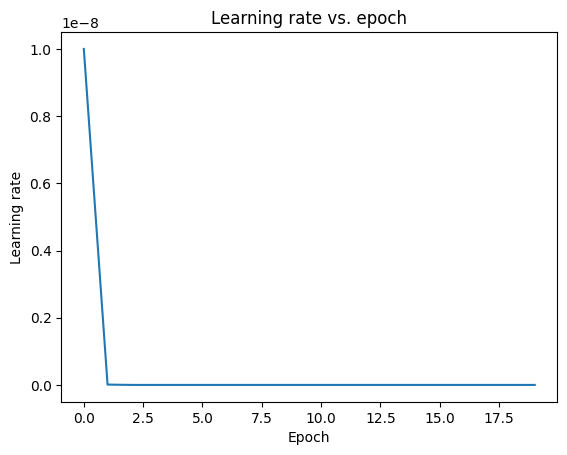

In [23]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR

# Define the model and optimizer
model = torch.nn.Sequential(
    torch.nn.Linear(10, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
)
optimizer = optim.AdamW(model.parameters(), lr=0.01)

# Define the number of warmup steps and the maximum learning rate
warmup_steps = 100
max_lr = 0.05
step=0

# Define the warmup scheduler
warmup_scheduler = LinearLR(optimizer, start_factor=0.001, total_iters=warmup_steps)

# Define the cosine annealing scheduler
#cosine_scheduler = CosineAnnealingLR(optimizer, T_max=20*100-warmup_steps, eta_min=0)

# Define the lambda function that returns the learning rate based on the current epoch
def get_lr(epoch):
    if epoch < warmup_steps:
        return warmup_scheduler.get_lr()[0]
    else:
        #return cosine_scheduler.get_lr()[0]
        pass 

# Define the number of epochs and the learning rate list
num_epochs = 20
lr_list = []

# Loop over the epochs
for epoch in range(num_epochs):

    # Update the learning rate
    lr = get_lr(epoch)
    lr_list.append(lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Loop over the "spochs" (sub-epochs)
    num_spochs = 100
    for spoch in range(num_spochs):

        # Forward pass
        inputs = torch.randn(10, 10)
        outputs = model(inputs)
        targets = torch.randn(10, 1)
        loss = nn.MSELoss()(outputs, targets)

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step+=1
    
    
    #warmup_scheduler.step()
    

# Plot the learning rate using matplotlib
plt.plot(lr_list)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning rate vs. epoch')
plt.show()


In [24]:
import math 
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

In [26]:
import torch 
import torch.nn as nn
import torch.optim as optim 

import pytorch_warmup as warmup

import matplotlib.pyplot as plt 